In [1]:
%matplotlib inline

# Do below if you want interactive matplotlib plot ()
# %matplotlib notebook 

# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# %install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas;

Software versions
Python 2.7.10 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.31)]
IPython 5.5.0
OS Darwin 17.0.0 x86_64 i386 64bit
numpy 1.13.3
scipy 0.19.1
matplotlib 2.1.0
pandas; Invalid requirement, parse error at "u';'"
Wed Nov 08 10:32:29 2017 CST

In [2]:
# standard library

# thirdparty library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# local imports

In [3]:
# customizations
sns.set()  # matplotlib defaults

# see value of statements at once
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# any tweaks that normally go in .matplotlibrc, etc., should explicitly go here
plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format = 'retina'

In [4]:
# global variables

passengers = pd.read_csv('./data/titanic-data.csv')

# Titanic: 具备哪些条件的人在灾难中更有可能生还

## 加载并检查数据

浏览原始数据，明确数据中各字段含义，其中：

> | Variable | Definition  |
| --- | --- |
| pclass | Ticket class(1 = 1st, 2 = 2nd, 3 = 3rd) |
| sibsp | # of siblings / spouses aboard the Titanic |
| parch | # of parents / children aboard the Titanic |
| embarked | Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton) |

> pclass: A proxy for socio-economic status (SES)
> 1st = Upper
> 2nd = Middle
> 3rd = Lower

> age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

> sibsp: The dataset defines family relations in this way...
> Sibling = brother, sister, stepbrother, stepsister
> Spouse = husband, wife (mistresses and fiancés were ignored)

> parch: The dataset defines family relations in this way...
> Parent = mother, father
> Child = daughter, son, stepdaughter, stepson
> Some children travelled only with a nanny, therefore parch=0 for them.

原始数据示例如下：

In [5]:
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


共有数据 891 条，分别为 891 名乘客的信息，其中不包含重复数据。我们关注的三个因变量（Pclass、Sex、Age）中，Pclass 和 Sex 均不存在空值，对于 Age 为空值的记录，做丢弃处理。

In [7]:
passengers.dropna(subset=['Age'], inplace=True)

对于年龄数据中存在小数点的情况，将其向上取整。

In [8]:
passengers.Age = passengers.Age.apply(np.ceil)

幸存者人数和遇难者人数统计如下：

In [9]:
passengers.groupby('Survived').PassengerId.count()

Survived
0    424
1    290
Name: PassengerId, dtype: int64

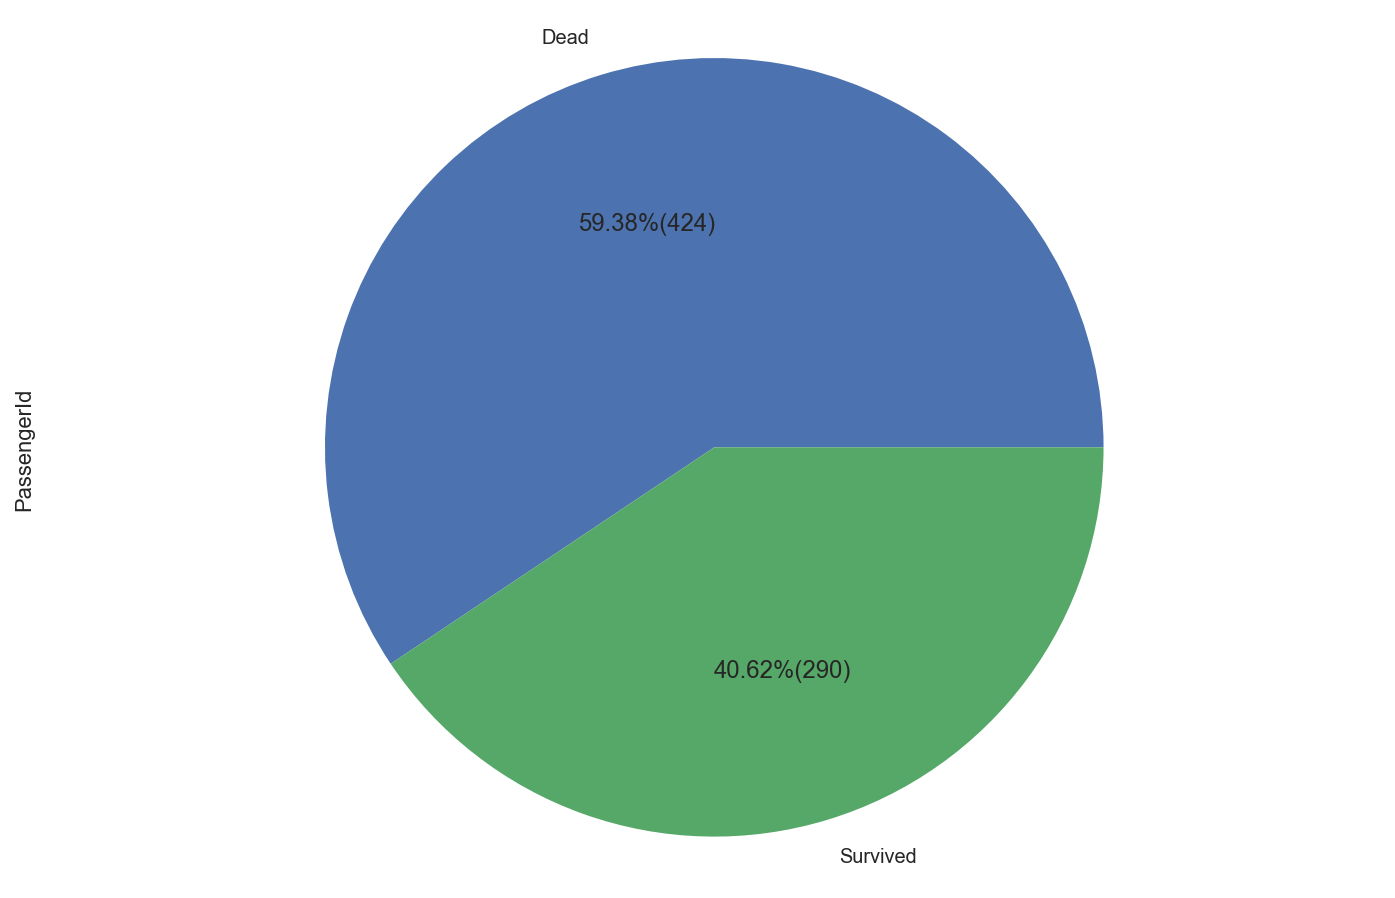

In [10]:
def percent_and_count(percent):
    return '%.2f%%(%d)' % (percent, int(percent / 100 * passengers.PassengerId.count()))

pie = passengers.groupby('Survived').PassengerId.count().plot.pie(labels=['Dead', 'Survived'], autopct=percent_and_count);
pie.axis('equal');

## 分析数据

现代社会中，当灾难发生时，逃生的妇孺优先原则是每个人都应该遵守的社会义务。下面就以性别、年龄等因素对于幸存与否的影响作为切入点，对现有数据进行分析。

### 1. 性别对于幸存与否的影响

选择饼图展示，可以清晰的看出男性与女性乘客幸存的比例。

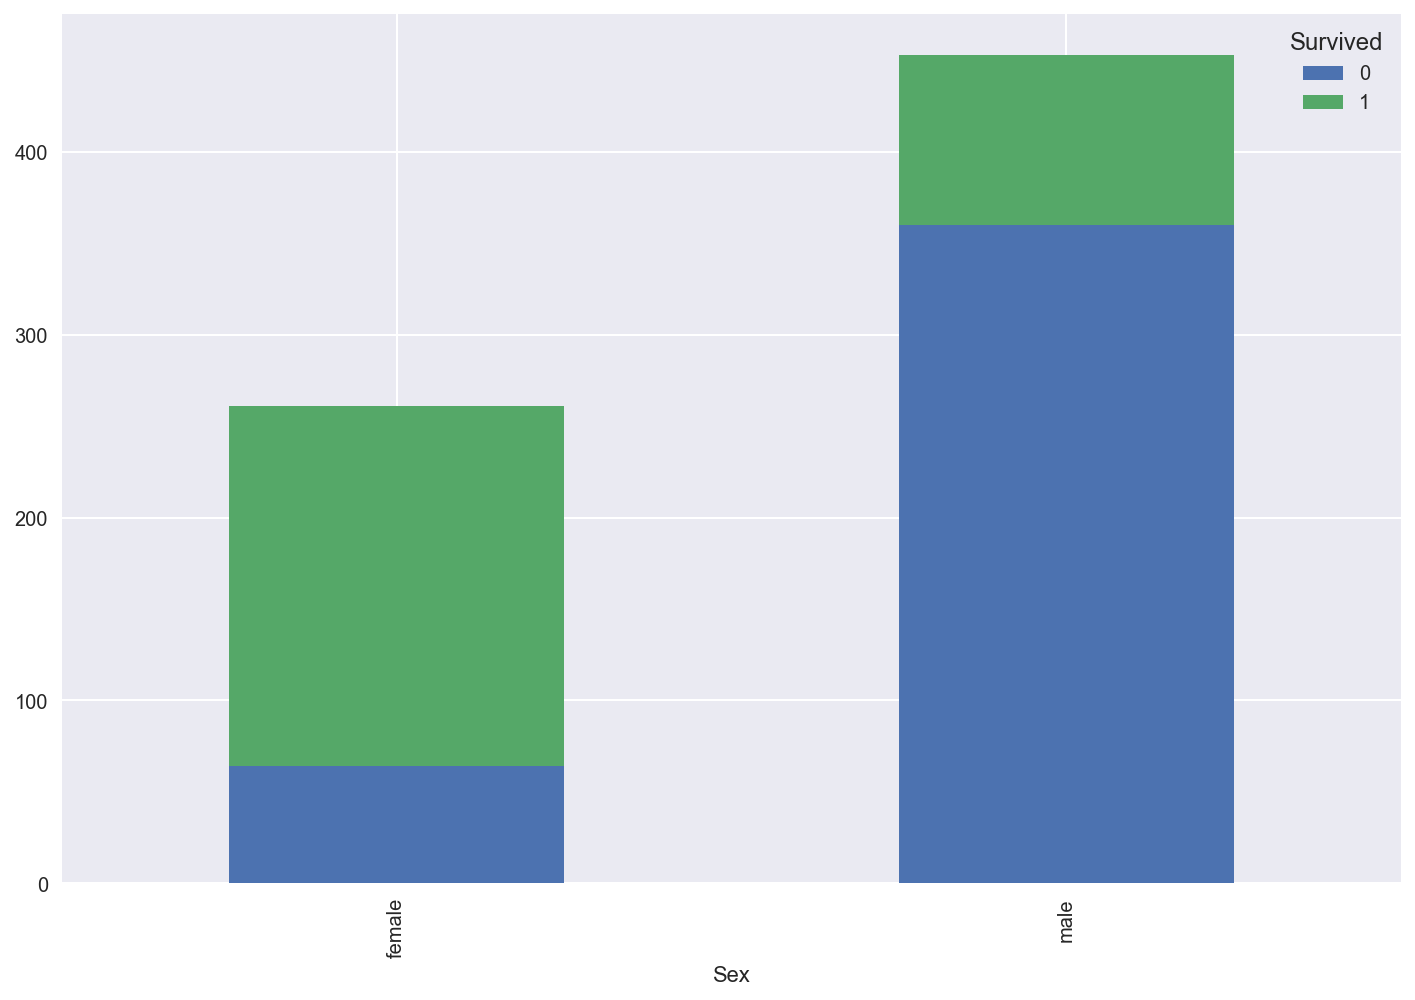

In [11]:
passengers.groupby(['Sex', 'Survived']).Survived.count().unstack().plot.bar(stacked=True);

从上图可以看出，在 Titanic 沉船事故中女性具有更高的幸存几率，幸存率分别为：

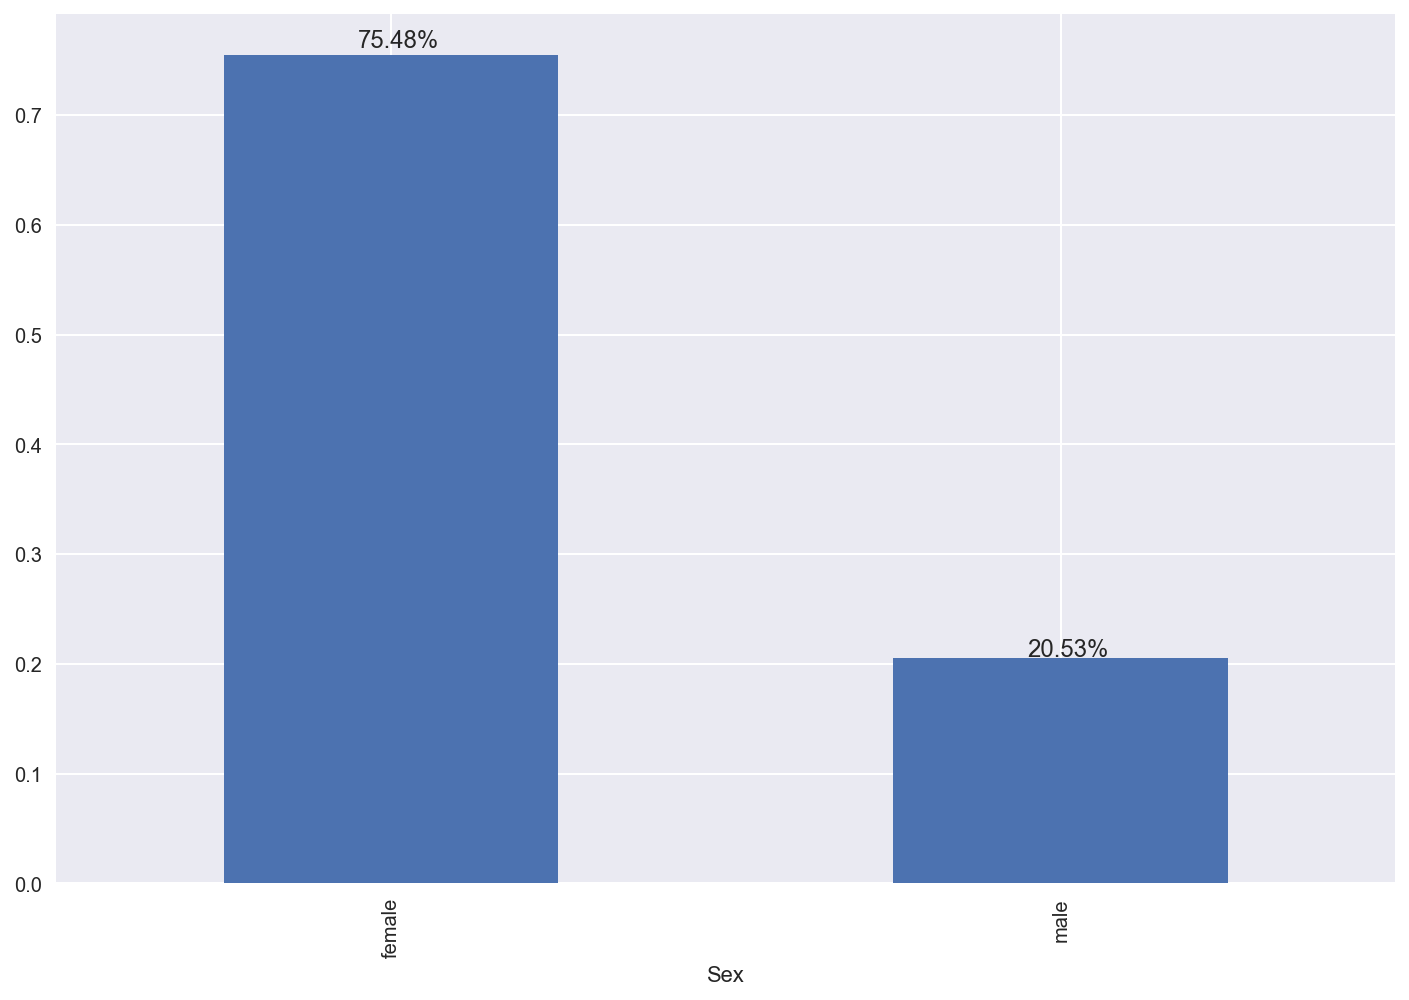

In [12]:
sex_axes = passengers.groupby('Sex').Survived.mean().plot.bar();
for p in sex_axes.patches:
    sex_axes.annotate('%.2f%%' % (p.get_height() * 100), (p.get_x() + p.get_width() / 2.5, p.get_height() * 1.01));

使用 X^2 检验计算性别与幸存与否的相关性。

In [13]:
frequency_table = pd.crosstab(passengers.Survived, passengers.Sex); frequency_table

Sex,female,male
Survived,,
0,64,360
1,197,93


In [14]:
chi2,pval,dof,expected = stats.chi2_contingency(frequency_table)
print 'Chi2 test statistic: {}'.format(chi2)
print 'p-value: {}'.format(pval)

Chi2 test statistic: 205.025827529
p-value: 1.67166784414e-46


P value 趋近于零，可见性别与幸存与否存在明显相关性。

## 2. 年龄对于幸存与否的影响

In [15]:
survivors_age = passengers[passengers.Survived == 1].Age
survivors_age.describe()

count    290.000000
mean      28.351724
std       14.939801
min        1.000000
25%       19.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

幸存乘客年龄分布，及其在全部乘客中所占比例如下：

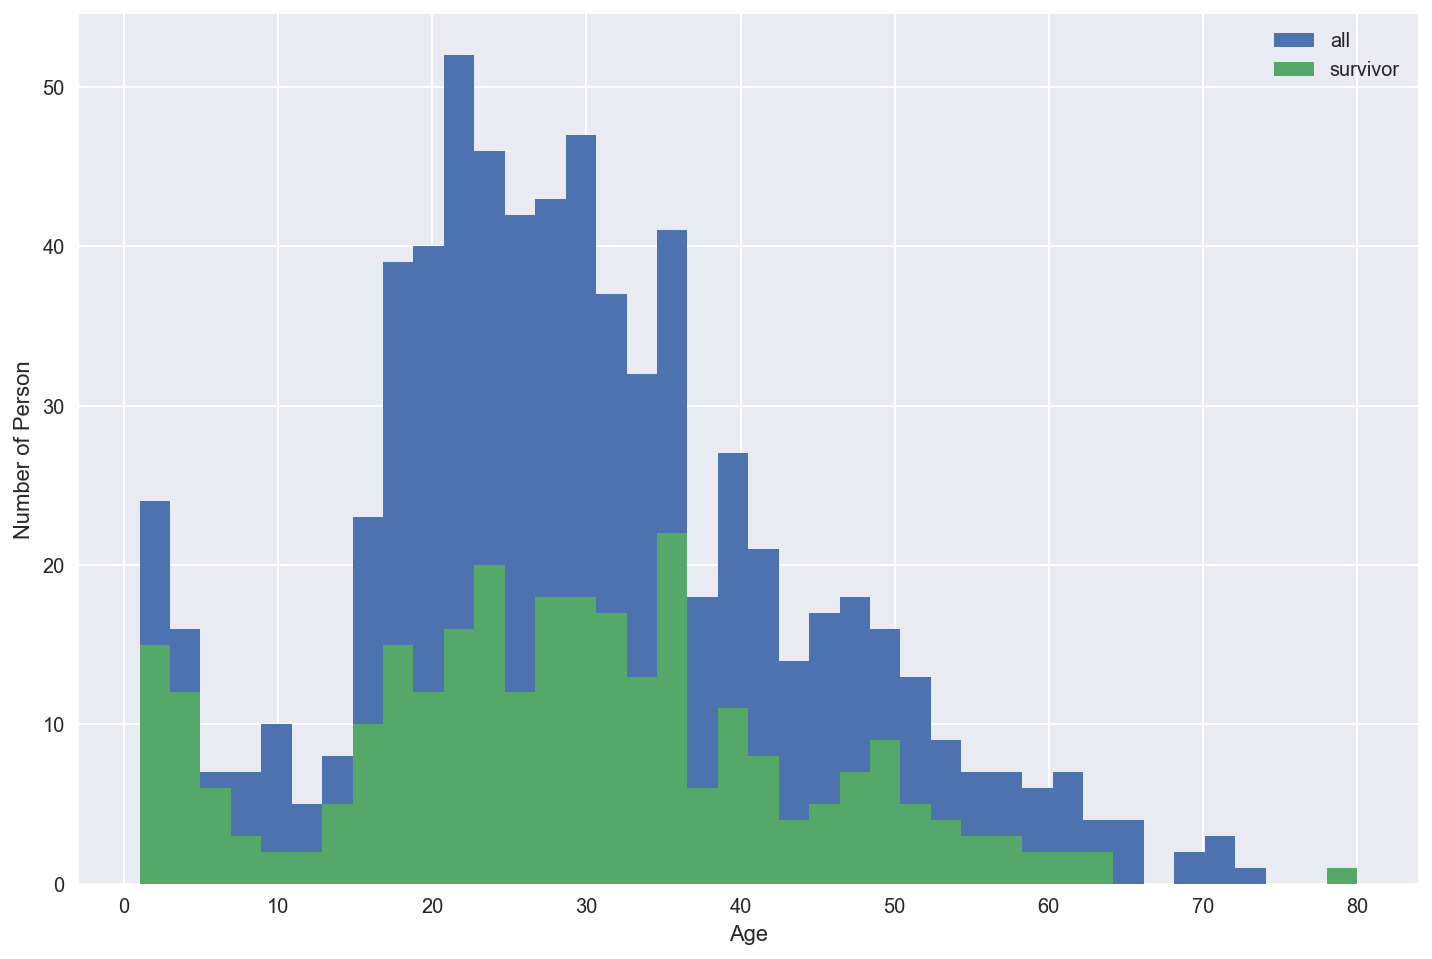

In [16]:
passengers_age = np.ceil(passengers.Age.dropna())
passengers_age.hist(bins=40);
survivors_age.hist(bins=40);
plt.xlabel('Age');
plt.ylabel('Number of Person');
plt.legend(['all', 'survivor']);

当灾难发生时，除了女性外，社会伦理导致小孩同样具有优先获救的可能。在 Titanic 沉船事故中，12 岁以下的小孩和其余成年人的幸存率分别为：

In [17]:
def child(index):
    if index <= 12:
        return 'child'
    else:
        return 'adult'
survivors_age.apply(child).value_counts() / passengers_age.apply(child).value_counts()

adult    0.387597
child    0.579710
Name: Age, dtype: float64

可见，在 Titanic 沉船事故中，小孩同样具有更高的幸存几率。同样使用 X^2 检验验证相关性。

In [18]:
crosstab = pd.crosstab(passengers.Survived, passengers_age.apply(child));crosstab

Age,adult,child
Survived,,
0,395,29
1,250,40


In [19]:
chi2,pval,dof,expected = stats.chi2_contingency(crosstab)
print 'p-value: {}'.format(pval)

p-value: 0.00308224671289


P-value 远小于 5%，说明 12 岁以下的小孩更有可能幸存。

## 3. Titanic 事件中是否存在“头等舱”妇孺优先的问题

在 Titanic 的电影中，有一个情节是为了保证头等舱中社会地位较高的乘客优先登上救生艇，船员们甚至临时关闭了下层夹板乘客通往船桥夹板的通道。这一现象在我们的统计数据中也得到了验证，社会经济地位高或中等的乘客的幸存比例远远高于社会地位较低的乘客。

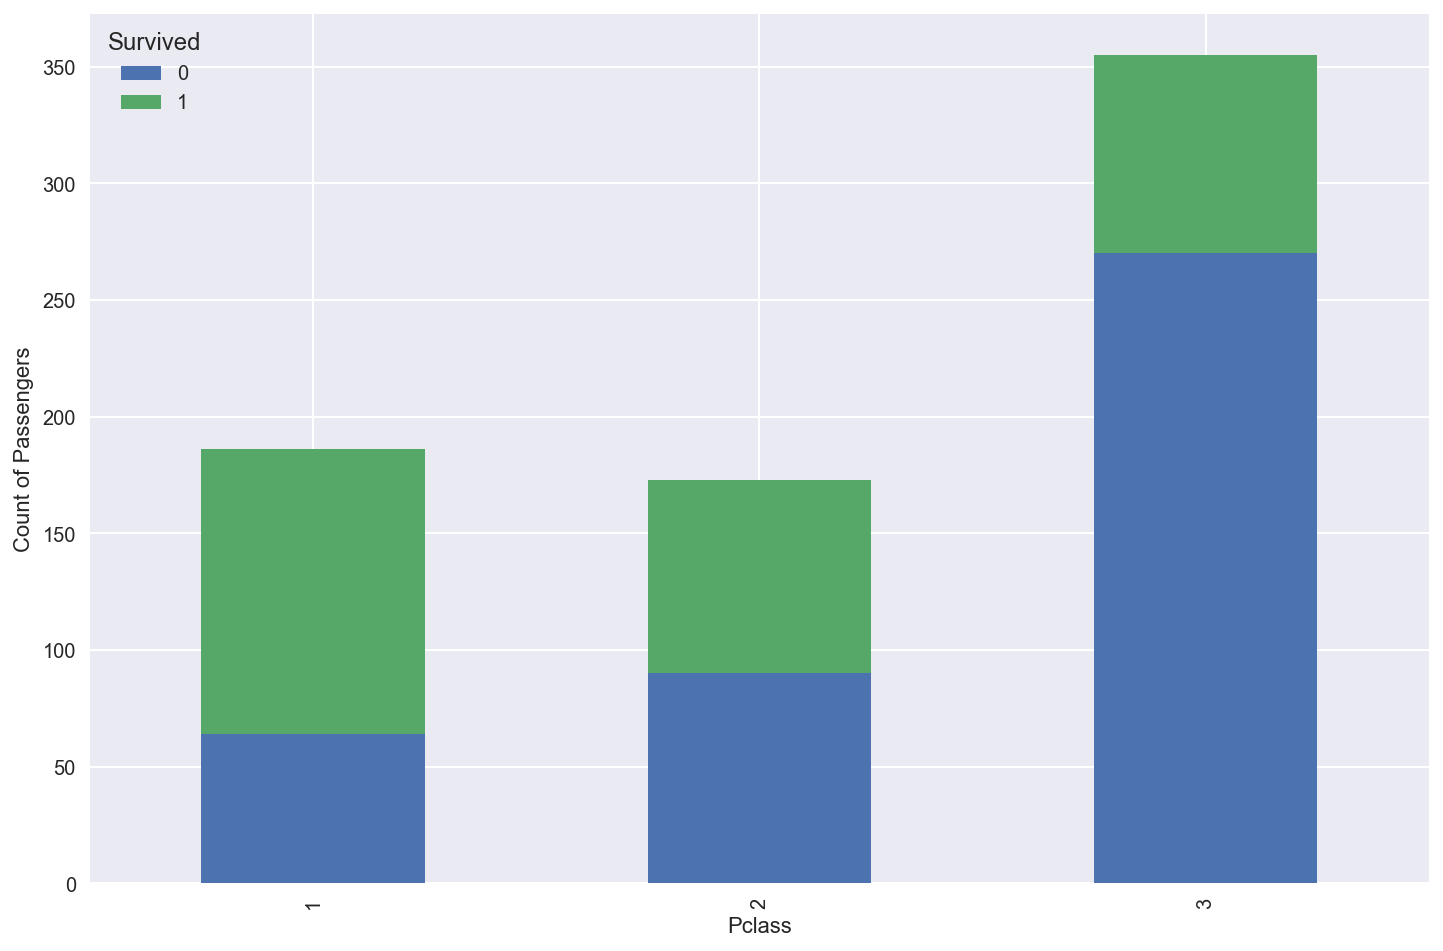

In [20]:
passengers.groupby(['Pclass', 'Survived']).Survived.count().unstack().plot.bar(stacked=True);
plt.ylabel('Count of Passengers');

灾难危机事件中，逃生的妇孺优先原则是现代社会人人都要遵守的义务。通过对于年龄和性别因素的分析，在 Titanic 灾难中，这一原则似乎有被遵守。但是也有一种说法认为，Titanic 遵守的只是"头等舱"乘客的妇孺优先原则。

In [21]:
female_child_fq = passengers[(passengers.Sex == 'female') | (passengers.Age <= 12)].groupby(['Pclass', 'Survived']).Survived.count().unstack()
female_child_fq

Survived,0,1
Pclass,,
1,3,85
2,6,77
3,71,56


通过上述统计数据也的确可以看出这样的趋势，社会经济地位高或中等的乘客中妇女和儿童绝大部分都已获救，但社会经济地位较低的乘客中的妇女和儿童获救的比例甚至不足 50%。

对上述频率表执行 X^2 检验：

In [22]:
chi2,pval,dof,expected = stats.chi2_contingency(female_child_fq)
print 'P-value: {}'.format(pval)

P-value: 1.84210077128e-21


P-value 的值接近于零。可见，妇女、儿童是否可以获救与他们的社会地位存在很强的相关性。

## 结论

在 Titanic 沉船事故中，妇孺优先原则能够被比较好的遵守。但是遗憾的是，最终能否获救与他们所处的社会地位仍然有很大关系。

但是，由于使用的数据集仅包含其中 891 名乘客的信息，而实际 Titanic 在事故发生时共载有乘客 2224 名。如果我们使用的数据集无法充分代表 Titanic 上的全部乘客，那么依据这一数据样本得出的所有结论也都存在偏差。另外，在分析数据之前对 Age 为 NaN 的数据执行的数据清理也可能导致结论的偏差。因为，基于当前样本，无法判断没有登记年龄信息的乘客是随机分布的还是有着某些特殊规律。如果由于某种特殊原因，没有登记年龄信息的乘客均为儿童，那么基于年龄因素得出的结论就是存在偏差的。

## References

* https://svds.com/jupyter-notebook-best-practices-for-data-science/
* https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
* http://wiki.mbalib.com/wiki/%E6%98%BE%E8%91%97%E6%80%A7%E6%A3%80%E9%AA%8C#.E6.98.BE.E8.91.97.E6.80.A7.E6.A3.80.E9.AA.8C.E5.BA.94.E6.B3.A8.E6.84.8F.E7.9A.84.E9.97.AE.E9.A2.98